In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import os
import os
import numpy as np
import matplotlib.pyplot as plt
from pyemma.coordinates import tica
import warnings
warnings.filterwarnings("ignore")
plt.style.use(['science','no-latex'])
name_dict = {'pre': 'QM (1k) Training',
             'post': 'QM (1k) + Observable Training',
             '10k': 'QM (10k) Training',
             '50k': 'QM (50k) Training'}
import matplotlib.pylab as pylab
params = {'figure.dpi': 600,
            'axes.labelsize': 'medium',
          'legend.fontsize': 'medium',
         'axes.titlesize':'large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

            

def plot_stability_distribution(molecule, exp_dir):
    inference_dir = os.path.join(exp_dir, 'inference')
    plt.figure()
    for name in os.listdir(inference_dir):
        stab = np.load(os.path.join(inference_dir, name, 'replicas_stable_time.npy'))
        plt.hist(stab, label = name_dict[name], density=True, alpha=0.7)
    plt.title(molecule, fontsize=18)
    plt.legend(loc = 'upper right')
    plt.xlabel(f"Stable Simulation Time (ps)", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    

    
def plot_rdfs(ax, molecule, exp_dir):
    inference_dir = os.path.join(exp_dir, 'inference')
    gt_rdf = np.load(os.path.join(exp_dir, 'gt_rdf.npy'))
    ax.plot(np.linspace(0, 10, 500), gt_rdf, label="True", color = "b")
    for name in os.listdir(inference_dir):
        rdfs = []
        for i in range(300):
            path = os.path.join(inference_dir, name, f'rdf_epoch{i+1}.npy')
            if not os.path.exists(path):
                break
            rdfs.append(np.load(path))
        ax.plot(np.linspace(0, 10, 500), np.stack(rdfs).mean(0), label=name_dict[name], color = "orange")
    ax.set_title("Distribution of Interatomic Distances", fontsize=18)
    ax.legend(loc = 'upper right')
    ax.set_xlabel(f"r (Angstroms)", fontsize=14)
    ax.set_ylabel("h(r)", fontsize=14)

def plot_adfs(ax, molecule, exp_dir):
    inference_dir = os.path.join(exp_dir, 'inference')
    gt_adf = np.load(os.path.join(exp_dir, 'gt_adf.npy'))
    ax.plot(gt_adf, label="True", color = 'b')
    for name in os.listdir(inference_dir):
        adfs = []
        for i in range(300):
            path = os.path.join(inference_dir, name, f'adf_epoch{i+1}.npy')
            if not os.path.exists(path):
                break
            adfs.append(np.load(path))
        ax.plot(np.stack(adfs).mean(0), label=name_dict[name], color = 'orange')
    ax.set_title('Angular Distribution Function', fontsize = 18)
    ax.legend(loc = 'upper left')
    ax.set_xlabel(f"Angle (degrees)", fontsize=14)
    ax.set_ylabel("ADF", fontsize=14)

def plot_vacfs(ax, molecule, exp_dir):
    inference_dir = os.path.join(exp_dir, 'inference')
    gt_vacf = np.load(os.path.join(exp_dir, 'gt_vacf.npy'))
    x_axis = np.linspace(0, int(gt_vacf.shape[0] / 2), gt_vacf.shape[0])
    ax.plot(x_axis, gt_vacf, label="True", color = 'b')
    for name in os.listdir(inference_dir):
        vacfs = []
        for i in range(300):
            path = os.path.join(inference_dir, name, f'vacf_epoch{i+1}.npy')
            if not os.path.exists(path):
                break
            vacfs.append(np.load(path))
        ax.plot(x_axis, np.stack(vacfs).mean(0), label=name_dict[name], color = 'orange')
    ax.set_title('Velocity Autocorrelation Function', fontsize=18)
    ax.legend(loc = 'upper right')
    ax.set_xlabel(f"Time lag (fs)", fontsize=14)
    ax.set_ylabel("Normalized VACF", fontsize=14)

def plot_observables_combined(molecule, exp_dir):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    plot_rdfs(axes[0], molecule, exp_dir)
    plot_adfs(axes[1], molecule, exp_dir)
    plot_vacfs(axes[2], molecule, exp_dir)
    plt.tight_layout()
    plt.show()
    

def plot_tic(molecule, exp_dir, gt_dir):
    LAG = 50
    gt_traj = np.load(gt_dir)
    gt_traj = gt_traj.f.R.reshape(gt_traj.f.R.shape[0], -1)
    projected_data_gt = tica(gt_traj, lag=LAG, dim=2).get_output()[0]
    
    pred_traj = np.load(os.path.join(exp_dir, 'inference', 'post', 'full_traj.npy'))
    import pdb; pdb.set_trace()
    #this is incorrect because we have multiple replicas - need to somehow average over many trajectories
    pred_traj = pred_traj.reshape(pred_traj.shape[0], -1)
    projected_data_pred = tica(gt_traj, lag=int(LAG/50), dim=2).get_output()[0]
    
    # Determine common color scale limits
    h1, _, _ = np.histogram2d(projected_data_gt[:, 0], projected_data_gt[:, 1], bins=(100, 100))
    h2, _, _ = np.histogram2d(projected_data_pred[:, 0], projected_data_pred[:, 1], bins=(100, 100))
    vmin = min(h1.min(), h2.min())
    vmax = max(h1.max(), h2.max())
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot data on the first axis
    c1 = ax1.hist2d(projected_data_gt[:, 0], projected_data_gt[:, 1], bins=(100, 100), vmin=vmin, vmax=vmax, cmap = 'viridis')
    ax1.set_xlabel("TIC1", fontsize=14)
    ax1.set_ylabel("TIC2", fontsize=14)
    ax1.set_title('Reference', fontsize=18)

    # Plot data on the second axis
    c2 = ax2.hist2d(projected_data_pred[:, 0], projected_data_pred[:, 1], bins=(100, 100), vmin=vmin, vmax=vmax, cmap = 'viridis')
    ax2.set_xlabel("TIC1", fontsize=14)
    ax2.set_ylabel("TIC2", fontsize=14)
    ax2.set_title('Finetuned Schnet model', fontsize=18)

    # Add a single colorbar to the figure
    fig.colorbar(c1[3], ax=[ax1, ax2], orientation='vertical', pad=0.05)
    plt.show()


    


    

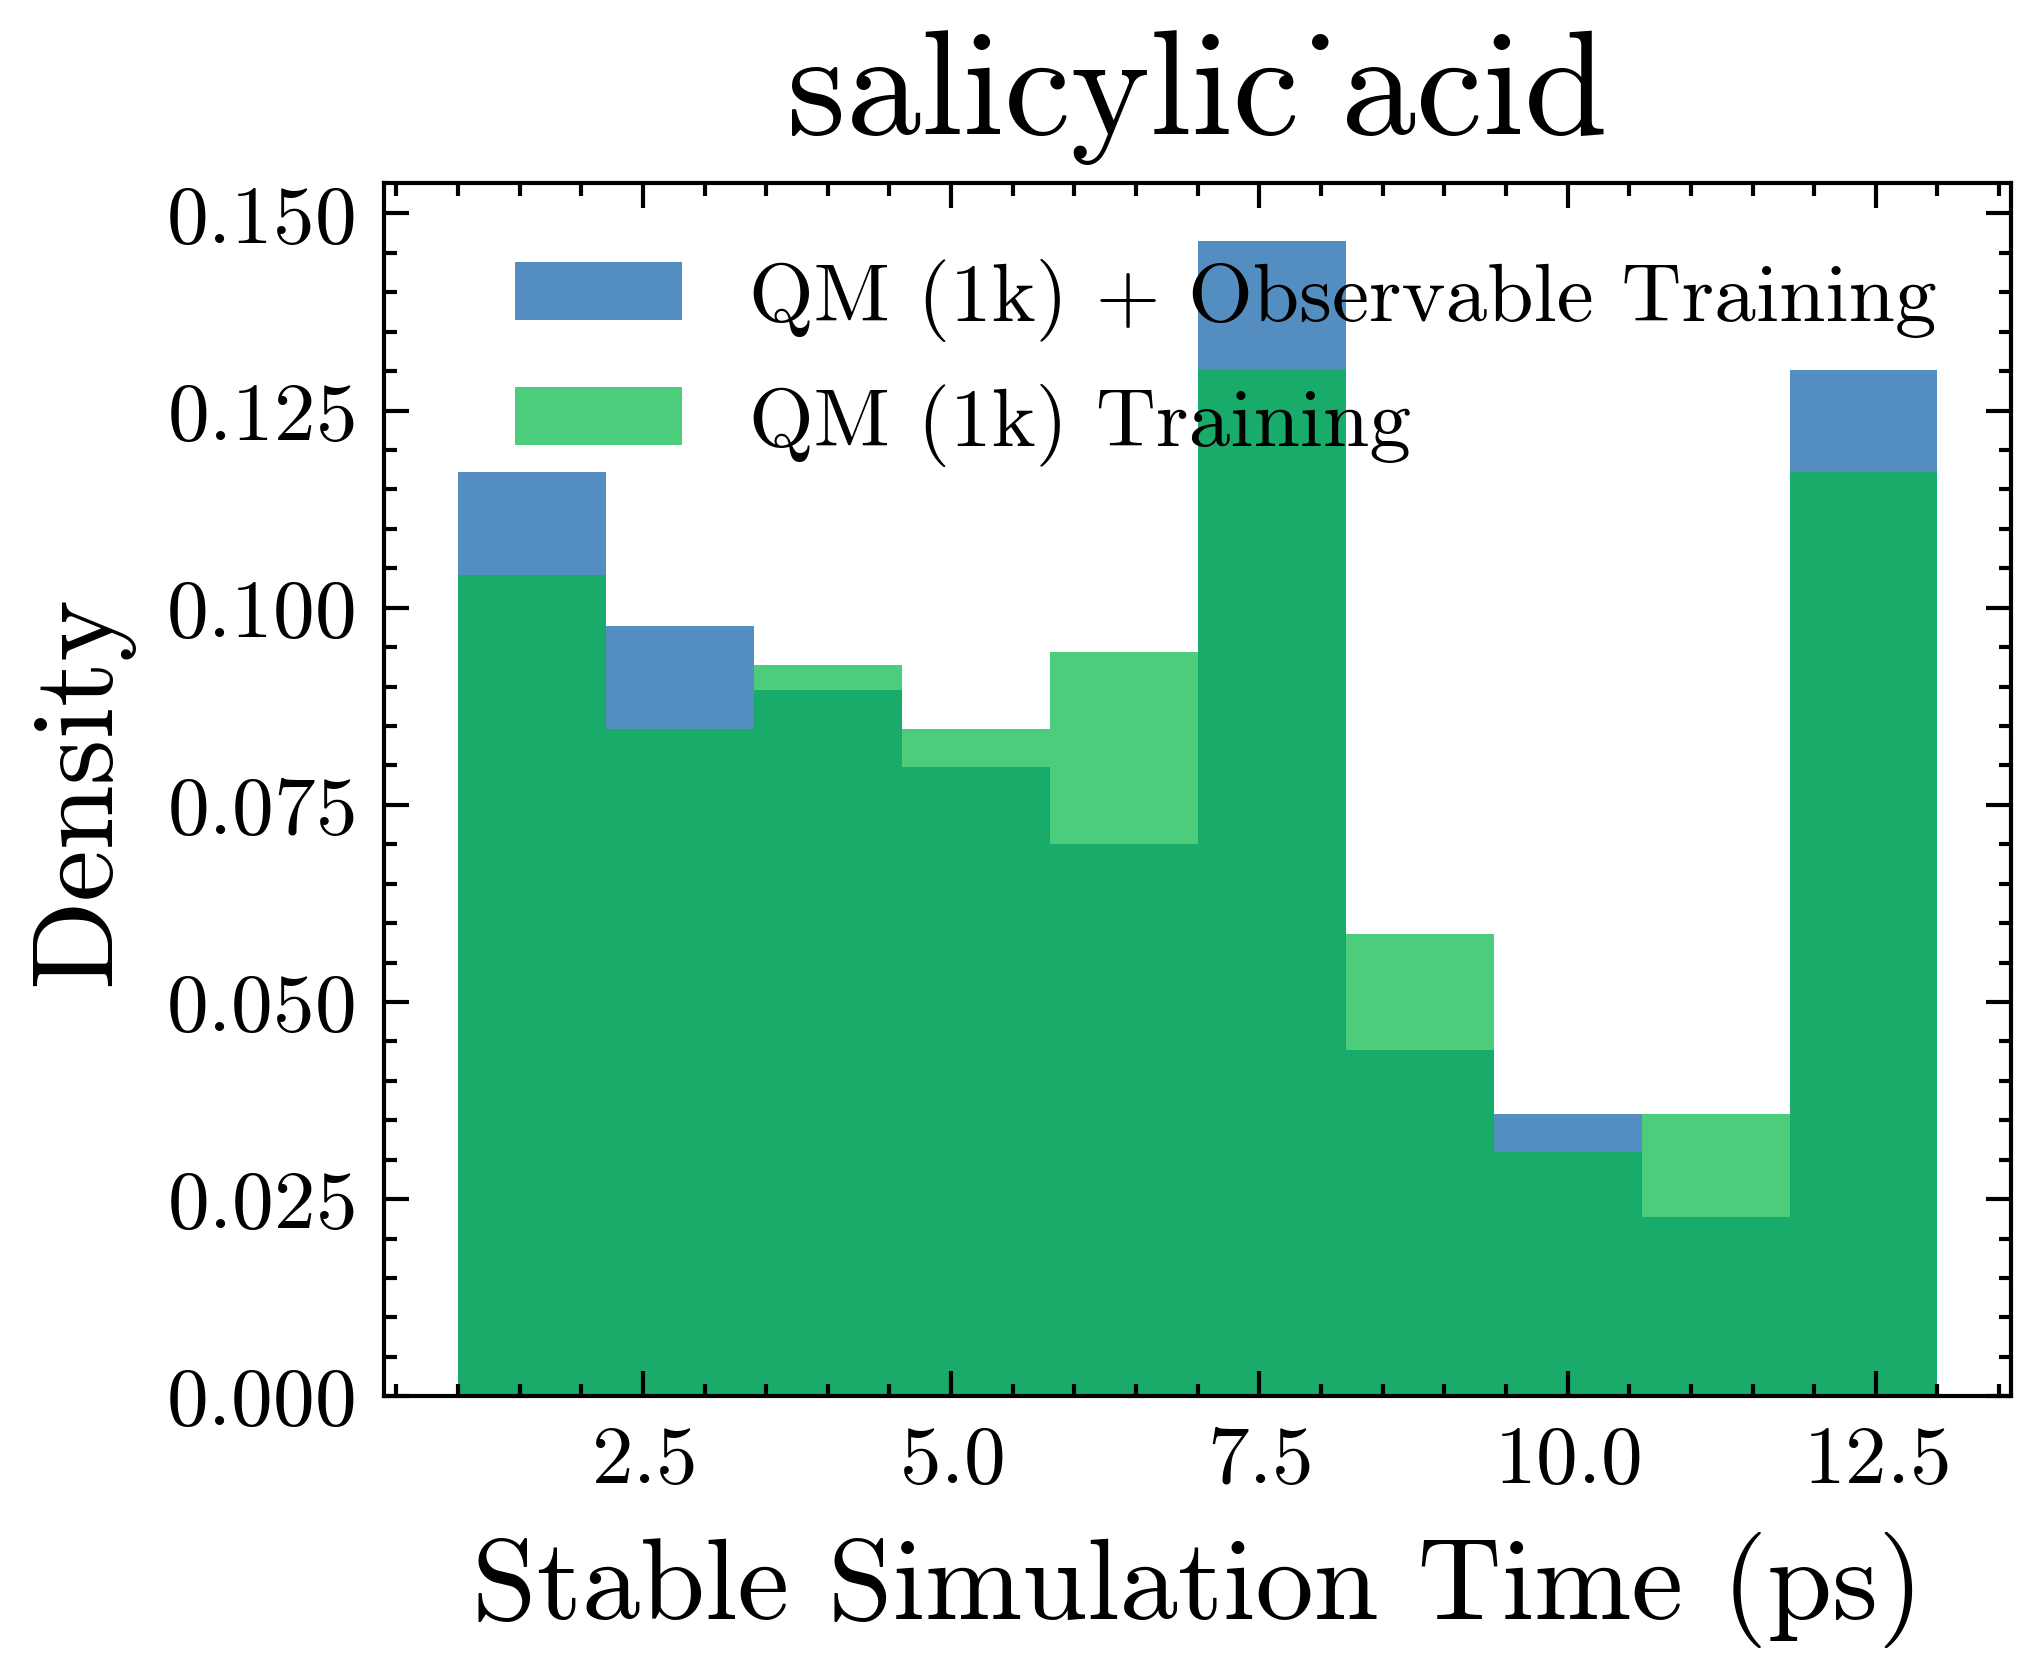

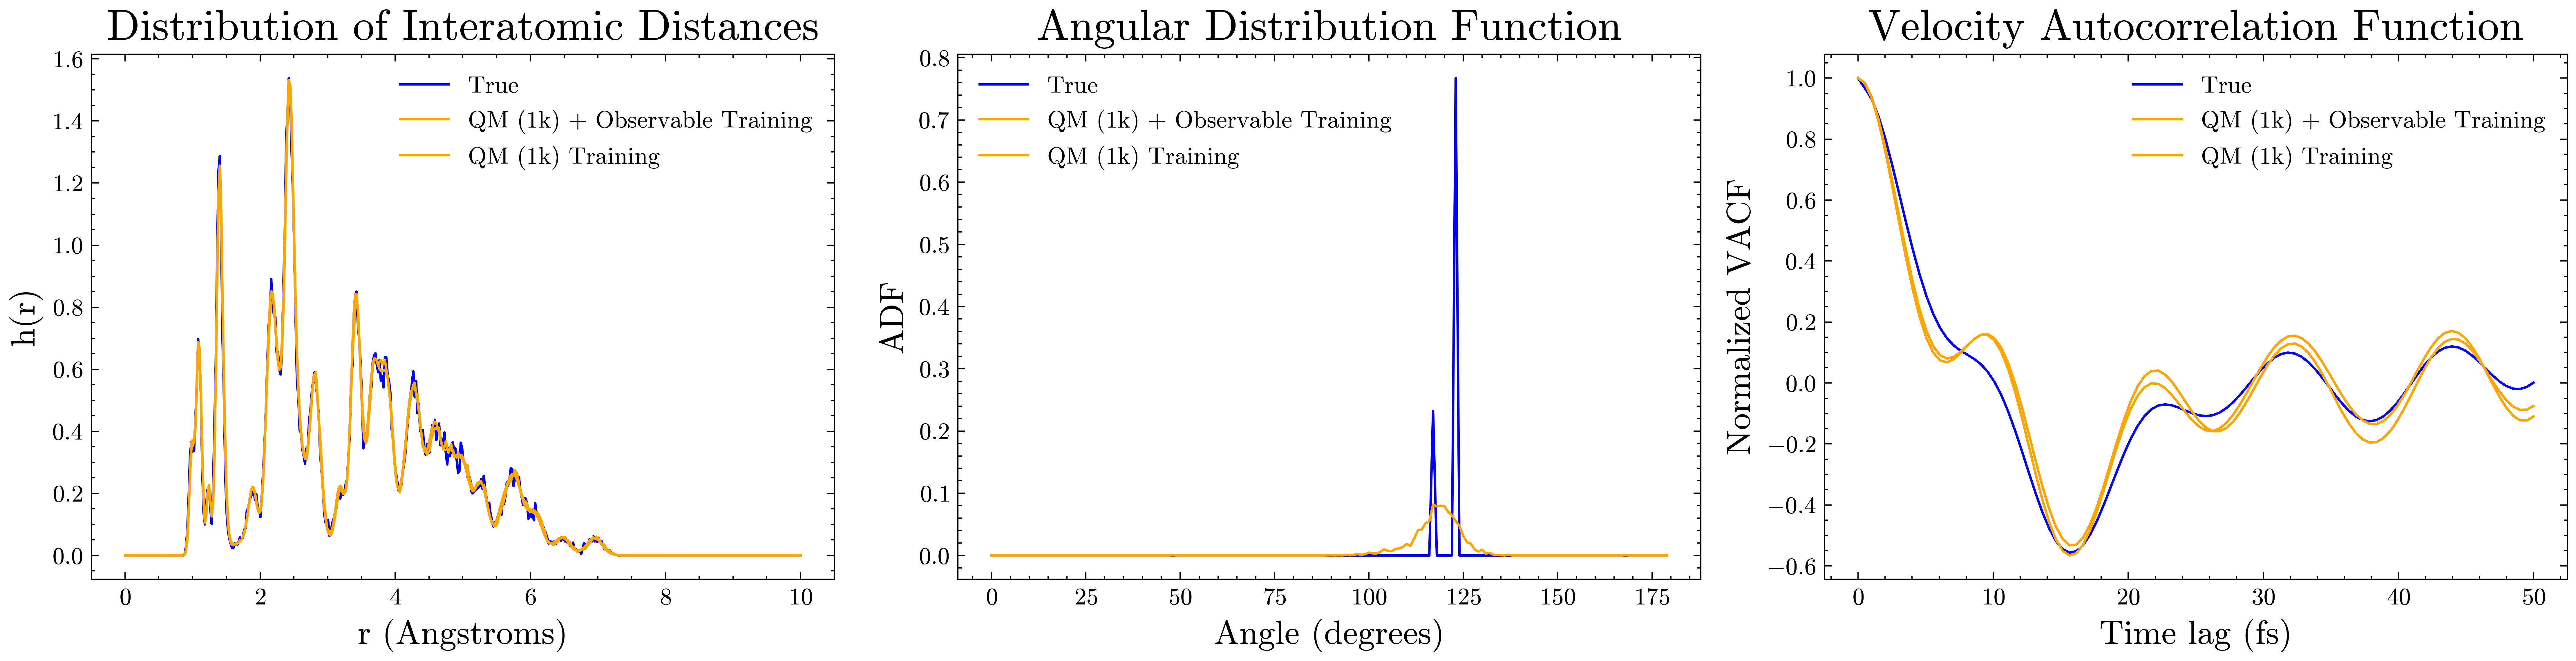

> /tmp/ipykernel_331678/3922023720.py(110)plot_tic()
    108     pred_traj = np.load(os.path.join(exp_dir, 'inference', 'post', 'full_traj.npy'))
    109     import pdb; pdb.set_trace()
--> 110     pred_traj = pred_traj.reshape(pred_traj.shape[0], -1)
    111     projected_data_pred = tica(gt_traj, lag=int(LAG/50), dim=2).get_output()[0]
    112 

ipdb> pred_traj.shape
(520, 512, 16, 3)


In [ ]:
molecule = 'salicylic_acid'
exp_dir = '/global/cfs/projectdirs/m4319/sanjeevr/results_md17_hpo/IMPLICIT_schnet_salicylic_acid_HPO_lr=0.001_efweight=3'
gt_dir = f'/pscratch/sd/s/sanjeevr/contiguous-md17/{molecule}/10k/val/nequip_npz.npz'
plot_stability_distribution(molecule, exp_dir)
plot_observables_combined(molecule, exp_dir)
plot_tic(molecule, exp_dir, gt_dir)
